## Data Preprocessing

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

batch_size = 64

# Tensor and Normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Augmentation should be applied before ToTensor
    transforms.RandomCrop(32, padding=4), # slightly shifted in position
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), # mean of RGB
                         (0.5,0.5,0.5)), # standard deviation of RGB

])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), # mean of RGB
                         (0.5,0.5,0.5)) # standard deviation of RGB
])

# Train Dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform = train_transform
    )

# Valid Dataset
validset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform = test_transform
    )

# Test Dataset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform = test_transform
    )

# Set up valid dataset
train_size = int(0.9 * len(trainset))   # 90%
valid_size = len(trainset) - train_size # 10%

train_idx, valid_idx = torch.utils.data.random_split(range(len(trainset)), [train_size, valid_size])

# Subset으로 index만 나눔
train_subset = torch.utils.data.Subset(trainset, train_idx)
valid_subset = torch.utils.data.Subset(validset, valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_subset, batch_size=batch_size, shuffle=True, num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    valid_subset, batch_size=batch_size, shuffle=False, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

torch.Size([64, 3, 32, 32])
torch.Size([64])
cat


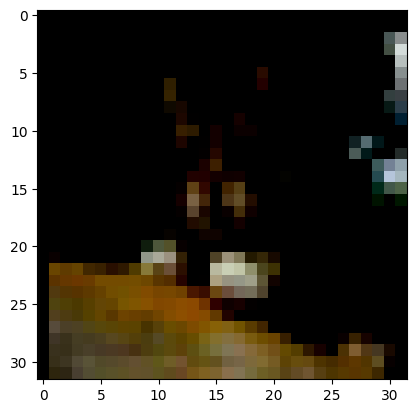

In [ ]:
from matplotlib.pyplot import imshow

def showing_images(tensor_image):
  # [C, H, W] → [H, W, C]
  image = tensor_image.permute(1, 2, 0)
  imshow(image) # Show image as [H,W]

images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)
image1, label1 = images[0], labels[0]
showing_images(image1) # Show image
print(classes[label1])

In [ ]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

704
79
157


## ViT Architecture

In [ ]:
# P = 7, img_size = 32, in_chan = 3, d_model = 192, num_heads, hidden_dim, drop_out=0.1
# P, img_size, in_chan, d_model, num_heads, hidden_dim, drop_out, num_layers, num_classes
from dataclasses import dataclass

@dataclass
class ViTConfig:
  # Hyperparameters for ViT
  P = 4
  img_size = 32
  in_chan = 3
  d_model = 192
  hidden_dim = 768
  num_heads = 4
  drop_out = 0.1
  num_layers = 4
  num_classes = 10
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math

class Embedding(nn.Module):
  def __init__(self, P, img_size, in_chan, d_model):
    super().__init__()
    self.P = P
    self.cls_token = nn.Parameter(
        torch.randn(1, 1, d_model)
    ) # To train, initializa in __init__
    self.proj = nn.Conv2d(
        in_channels=in_chan,
        out_channels=d_model,
        kernel_size=P,
        stride=P
    ) # To train, initializa in __init__
    seq_len = (img_size // P) ** 2
    self.pos_emb = nn.Parameter(
      torch.randn(1, seq_len+1, d_model)
    ) # To train, initializa in __init__

  def patch_embedding(self, flatten_patches):
    B = flatten_patches.size(0)
    cls_token = self.cls_token.expand(B, -1, -1) # To avoid training in the first dimension
    new_patches = torch.cat([cls_token, flatten_patches], dim=1) # (B, seq_len+1, d_model)
    return new_patches

  def positional_embedding(self, flatten_patches):
    return flatten_patches + self.pos_emb

  def forward(self, x): # x.shape : [B, 3, 32, 32]
    B, C, H, W = x.size()

    out = self.proj(x) # [B, d_model, H/P, W/P]
    out = out.flatten(2).transpose(1,2) # [B, d_model, HW/P^2] -> [B, HW/P^2, d_model] = [B, seq_len, d_model]
    out = self.patch_embedding(out) # [B, seq_len+1, d_model]
    out = self.positional_embedding(out) # [B, seq_len+1, d_model]
    return out

class MultiHeadSelfAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super().__init__()
    assert d_model % num_heads == 0
    self.d_model = d_model
    self.num_heads = num_heads

    self.q = nn.Linear(d_model, d_model)
    self.k = nn.Linear(d_model, d_model)
    self.v = nn.Linear(d_model, d_model)
    self.o = nn.Linear(d_model, d_model)

    self.d_k = d_model // num_heads
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    B, seq_len2, _ = x.size() # [B, seq_len+1, d_model]
    q = self.q(x) # [B, seq_len+1, d_model]
    k = self.k(x)
    v = self.v(x)

    q = q.view(B, seq_len2, self.num_heads, self.d_k).transpose(1,2) # [B, num_heads, seq_len+1, d_k]
    k = k.view(B, seq_len2, self.num_heads, self.d_k).transpose(1,2)
    v = v.view(B, seq_len2, self.num_heads, self.d_k).transpose(1,2)

    attn = torch.matmul(q, k.transpose(-1,-2)) / math.sqrt(self.d_k) # [B, num_heads, seq_len+1, seq_len+1]
    attn = self.softmax(attn) # There is no masking due to characteristic of image data (Don't need to mask the future token in images)
    res = torch.matmul(attn, v) # [B, num_heads, seq_len+1, d_k]
    res = res.transpose(1,2).contiguous().view(B, seq_len2, self.d_model) # [B, seq_len+1, d_model]
    res = self.o(res) # [B, seq_len+1, d_model]
    return res

class MLP_Block(nn.Module):
  def __init__(self, d_model, hidden_dim, drop_out):
    super().__init__()
    self.linear1 = nn.Linear(d_model, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, d_model)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout(drop_out)

  def forward(self, x):
    x = self.linear1(x) # [B, seq_len+1, hidden_dim]
    x = self.gelu(x)
    x = self.dropout(x)
    x = self.linear2(x) # [B, seq_len+1, d_model]
    x = self.dropout(x)
    return x

class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, hidden_dim, drop_out):
    super().__init__()
    self.MSA = MultiHeadSelfAttention(d_model, num_heads)
    self.MLP = MLP_Block(d_model, hidden_dim, drop_out=drop_out)
    self.LN1 = nn.LayerNorm(d_model)
    self.LN2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(drop_out)

  def forward(self, x):
    out1 = self.MSA(self.LN1(x)) # [B, seq_len+1, d_model]
    out1 = self.dropout(out1) + x
    out2 = self.MLP(self.LN2(out1)) + out1 # [B, seq_len+1, d_model]
    return out2

class ViT(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.linear = nn.Linear(config.d_model, config.num_classes) # Due to using not much big dataset as pre-training, use classification head in fine-tuning
    self.dropout = nn.Dropout(config.drop_out)
    self.Emb = Embedding(config.P, config.img_size, config.in_chan, config.d_model)
    self.layers = nn.ModuleList([
        EncoderLayer(config.d_model, config.num_heads, config.hidden_dim, config.drop_out) for _ in range(config.num_layers)
    ])

  def forward(self, x):
    out = self.Emb(x) # [B, seq_len+1, d_model]
    out = self.dropout(out)
    for layer in self.layers:
      out = layer(out)
    cls_token = out[:,0] # [B, d_model]
    out = self.linear(cls_token) # CrossEntropy has softmax in itself. Therefore, not use activation function after linear. [B, num_classes]
    return out

## Training & Evaluation

In [ ]:
import os
import torch.optim as optim
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = ViTConfig.device
print(device)
model = ViT(ViTConfig).to(device)
print(ViTConfig.device) # Check device is GPU or CPU
print(model)

cuda
cuda
ViT(
  (linear): Linear(in_features=192, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (Emb): Embedding(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (MSA): MultiHeadSelfAttention(
        (q): Linear(in_features=192, out_features=192, bias=True)
        (k): Linear(in_features=192, out_features=192, bias=True)
        (v): Linear(in_features=192, out_features=192, bias=True)
        (o): Linear(in_features=192, out_features=192, bias=True)
        (softmax): Softmax(dim=-1)
      )
      (MLP): MLP_Block(
        (linear1): Linear(in_features=192, out_features=768, bias=True)
        (linear2): Linear(in_features=768, out_features=192, bias=True)
        (gelu): GELU(approximate='none')
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LN1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (LN2): LayerNorm((192,), eps=1e-05, elementwise_affine=T

In [ ]:
num_epochs = 25

In [ ]:
# loss, optimizer, scheduler, evaluation, training loop

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
def evaluation(model, dataloader, loss_function, device):
  model.eval()
  total_loss = 0.0
  total_cnt = 0
  total_correct = 0

  with torch.no_grad():
    for image, label in dataloader:
      image = image.to(device) # [B, in_chan, H, W]
      label = label.to(device) # [B]

      output = model(image) # [B, num_classes]
      loss = loss_function(output, label)
      total_loss += loss.item()
      total_correct += (output.argmax(dim=-1) == label).sum().item()
      total_cnt += label.size(0)

  return total_loss / len(dataloader), total_correct / total_cnt

In [ ]:
# Training
from tqdm import tqdm

best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
  model.train()
  for image, label in train_loader:
    image = image.to(device)
    label = label.to(device)

    optimizer.zero_grad()

    output = model(image)
    loss = loss_function(output, label)

    loss.backward()
    optimizer.step()

  train_loss, train_acc = evaluation(model, train_loader, loss_function, device)
  valid_loss, valid_acc = evaluation(model, valid_loader, loss_function, device)

  print(f'Epoch : {epoch+1} / {num_epochs}')
  print(f'Train Loss : {train_loss:.4f} | Train Accuracy : {train_acc:.4f}')
  print(f'Valid Loss : {valid_loss:.4f} | Valid Accuracy : {valid_acc:.4f}')

  if valid_loss < best_val_loss:
    print(f'Valid loss improved from {best_val_loss:.4f} to {valid_loss:.4f}')
    print('체크 포인트를 저장합니다.')
    best_val_loss = valid_loss
    torch.save(model.state_dict(), 'best_ViT_checkpoint.pth')

  4%|▍         | 1/25 [00:58<23:17, 58.23s/it]

Epoch : 1 / 25
Train Loss : 1.6664 | Train Accuracy : 0.3941
Valid Loss : 1.5723 | Valid Accuracy : 0.4298
Valid loss improved from inf to 1.5723
체크 포인트를 저장합니다.


  8%|▊         | 2/25 [01:55<22:10, 57.83s/it]

Epoch : 2 / 25
Train Loss : 1.4836 | Train Accuracy : 0.4621
Valid Loss : 1.4266 | Valid Accuracy : 0.4842
Valid loss improved from 1.5723 to 1.4266
체크 포인트를 저장합니다.


 12%|█▏        | 3/25 [02:54<21:18, 58.11s/it]

Epoch : 3 / 25
Train Loss : 1.3873 | Train Accuracy : 0.4989
Valid Loss : 1.3388 | Valid Accuracy : 0.5174
Valid loss improved from 1.4266 to 1.3388
체크 포인트를 저장합니다.


 16%|█▌        | 4/25 [03:51<20:15, 57.88s/it]

Epoch : 4 / 25
Train Loss : 1.3642 | Train Accuracy : 0.5081
Valid Loss : 1.3508 | Valid Accuracy : 0.5176


 20%|██        | 5/25 [04:49<19:14, 57.72s/it]

Epoch : 5 / 25
Train Loss : 1.3024 | Train Accuracy : 0.5294
Valid Loss : 1.2682 | Valid Accuracy : 0.5422
Valid loss improved from 1.3388 to 1.2682
체크 포인트를 저장합니다.


 24%|██▍       | 6/25 [05:47<18:17, 57.77s/it]

Epoch : 6 / 25
Train Loss : 1.2531 | Train Accuracy : 0.5478
Valid Loss : 1.2432 | Valid Accuracy : 0.5504
Valid loss improved from 1.2682 to 1.2432
체크 포인트를 저장합니다.


 28%|██▊       | 7/25 [06:44<17:20, 57.81s/it]

Epoch : 7 / 25
Train Loss : 1.1969 | Train Accuracy : 0.5652
Valid Loss : 1.1945 | Valid Accuracy : 0.5730
Valid loss improved from 1.2432 to 1.1945
체크 포인트를 저장합니다.


 32%|███▏      | 8/25 [07:42<16:21, 57.72s/it]

Epoch : 8 / 25
Train Loss : 1.1735 | Train Accuracy : 0.5779
Valid Loss : 1.1527 | Valid Accuracy : 0.5798
Valid loss improved from 1.1945 to 1.1527
체크 포인트를 저장합니다.


 36%|███▌      | 9/25 [08:40<15:24, 57.76s/it]

Epoch : 9 / 25
Train Loss : 1.1288 | Train Accuracy : 0.5923
Valid Loss : 1.1279 | Valid Accuracy : 0.5998
Valid loss improved from 1.1527 to 1.1279
체크 포인트를 저장합니다.


 40%|████      | 10/25 [09:38<14:28, 57.88s/it]

Epoch : 10 / 25
Train Loss : 1.0712 | Train Accuracy : 0.6180
Valid Loss : 1.0791 | Valid Accuracy : 0.6212
Valid loss improved from 1.1279 to 1.0791
체크 포인트를 저장합니다.


 44%|████▍     | 11/25 [10:36<13:32, 58.04s/it]

Epoch : 11 / 25
Train Loss : 1.0668 | Train Accuracy : 0.6161
Valid Loss : 1.0973 | Valid Accuracy : 0.6120


 48%|████▊     | 12/25 [11:37<12:42, 58.69s/it]

Epoch : 12 / 25
Train Loss : 1.0313 | Train Accuracy : 0.6285
Valid Loss : 1.0548 | Valid Accuracy : 0.6170
Valid loss improved from 1.0791 to 1.0548
체크 포인트를 저장합니다.


 52%|█████▏    | 13/25 [12:36<11:46, 58.86s/it]

Epoch : 13 / 25
Train Loss : 0.9946 | Train Accuracy : 0.6433
Valid Loss : 1.0295 | Valid Accuracy : 0.6260
Valid loss improved from 1.0548 to 1.0295
체크 포인트를 저장합니다.


 56%|█████▌    | 14/25 [13:35<10:46, 58.81s/it]

Epoch : 14 / 25
Train Loss : 0.9726 | Train Accuracy : 0.6509
Valid Loss : 0.9943 | Valid Accuracy : 0.6474
Valid loss improved from 1.0295 to 0.9943
체크 포인트를 저장합니다.


 60%|██████    | 15/25 [14:32<09:45, 58.55s/it]

Epoch : 15 / 25
Train Loss : 0.9474 | Train Accuracy : 0.6617
Valid Loss : 0.9733 | Valid Accuracy : 0.6476
Valid loss improved from 0.9943 to 0.9733
체크 포인트를 저장합니다.


 64%|██████▍   | 16/25 [15:31<08:46, 58.46s/it]

Epoch : 16 / 25
Train Loss : 0.9332 | Train Accuracy : 0.6658
Valid Loss : 0.9938 | Valid Accuracy : 0.6478


 68%|██████▊   | 17/25 [16:29<07:47, 58.50s/it]

Epoch : 17 / 25
Train Loss : 0.8973 | Train Accuracy : 0.6778
Valid Loss : 0.9492 | Valid Accuracy : 0.6542
Valid loss improved from 0.9733 to 0.9492
체크 포인트를 저장합니다.


 72%|███████▏  | 18/25 [17:26<06:46, 58.11s/it]

Epoch : 18 / 25
Train Loss : 0.8564 | Train Accuracy : 0.6923
Valid Loss : 0.9295 | Valid Accuracy : 0.6644
Valid loss improved from 0.9492 to 0.9295
체크 포인트를 저장합니다.


 76%|███████▌  | 19/25 [18:25<05:49, 58.26s/it]

Epoch : 19 / 25
Train Loss : 0.8554 | Train Accuracy : 0.6938
Valid Loss : 0.9492 | Valid Accuracy : 0.6544


 80%|████████  | 20/25 [19:23<04:50, 58.19s/it]

Epoch : 20 / 25
Train Loss : 0.8654 | Train Accuracy : 0.6908
Valid Loss : 0.9467 | Valid Accuracy : 0.6626


 84%|████████▍ | 21/25 [20:22<03:53, 58.25s/it]

Epoch : 21 / 25
Train Loss : 0.8074 | Train Accuracy : 0.7114
Valid Loss : 0.9126 | Valid Accuracy : 0.6704
Valid loss improved from 0.9295 to 0.9126
체크 포인트를 저장합니다.


 88%|████████▊ | 22/25 [21:20<02:54, 58.28s/it]

Epoch : 22 / 25
Train Loss : 0.7720 | Train Accuracy : 0.7215
Valid Loss : 0.8747 | Valid Accuracy : 0.6884
Valid loss improved from 0.9126 to 0.8747
체크 포인트를 저장합니다.


 92%|█████████▏| 23/25 [22:18<01:56, 58.21s/it]

Epoch : 23 / 25
Train Loss : 0.7595 | Train Accuracy : 0.7258
Valid Loss : 0.8974 | Valid Accuracy : 0.6804


 96%|█████████▌| 24/25 [23:15<00:57, 57.94s/it]

Epoch : 24 / 25
Train Loss : 0.7367 | Train Accuracy : 0.7331
Valid Loss : 0.8710 | Valid Accuracy : 0.6970
Valid loss improved from 0.8747 to 0.8710
체크 포인트를 저장합니다.


100%|██████████| 25/25 [24:14<00:00, 58.17s/it]

Epoch : 25 / 25
Train Loss : 0.7358 | Train Accuracy : 0.7323
Valid Loss : 0.8750 | Valid Accuracy : 0.6866


In [ ]:
# Augmentation 을 고려해보자... 어지간하면 넣어야 할 듯...?
no_aug_valid_loss = [1.5357, 1.3956, 1.2876, 1.2225, 1.2128, 1.165, 1.1655, 1.1364, 1.1176, 1.0736, 1.093, 1.0982, 1.1144, 1.0817, 1.0944, 1.1174, 1.1525, 1.1868, 1.2221, 1.2041, 1.2487, 1.2626, 1.3288, 1.3699, 1.2979]
no_aug_valid_acc = [0.4534, 0.502, 0.5444, 0.5582, 0.5778, 0.5906, 0.5956, 0.5992, 0.6202, 0.627, 0.6252, 0.6348, 0.6246, 0.634, 0.6352, 0.6332, 0.6232, 0.628, 0.6288, 0.6362, 0.626, 0.631, 0.6234, 0.63321, 0.6448]
yes_aug_valid_loss = [1.5723, 1.4266, 1.3388, 1.3508, 1.2682, 1.2432, 1.1945, 1.1527, 1.1279, 1.0791, 1.0973, 1.0548, 1.0295, 0.9943, 0.9733, 0.9938, 0.9492, 0.9295, 0.9492, 0.9467, 0.9126, 0.8747, 0.8974, 0.8710, 0.8750]
yes_aug_valid_acc = [0.4298, 0.4842, 0.5174, 0.5176, 0.5422, 0.5504, 0.5730, 0.5798, 0.5998, 0.6212, 0.6120, 0.6170, 0.6260, 0.6474, 0.6476, 0.6478, 0.6542, 0.6644, 0.6544, 0.6626, 0.6704, 0.6884, 0.6804, 0.6970, 0.6866]

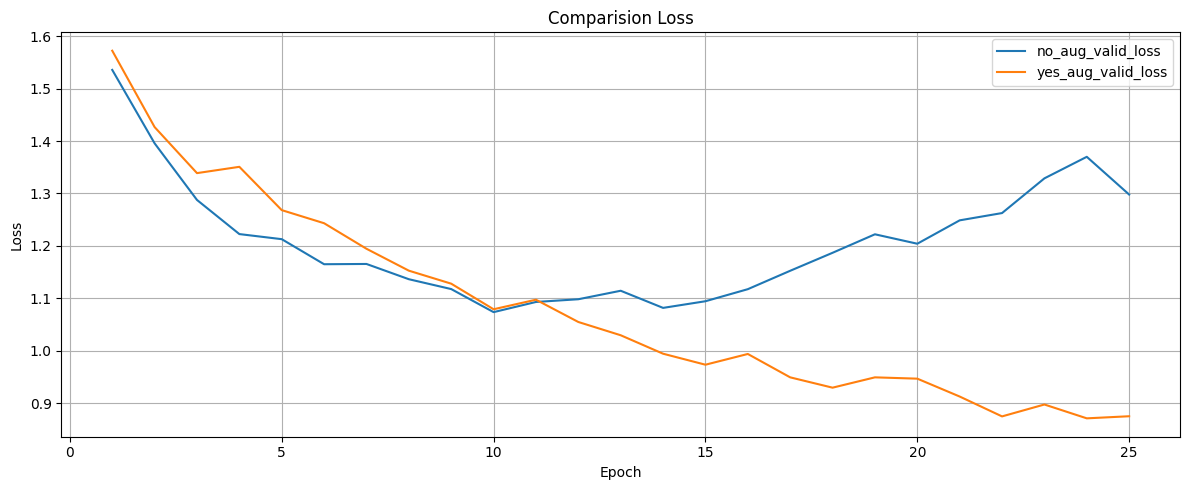

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1,26))

plt.figure(figsize=(12,5))

# Loss 그래프
plt.plot(epochs, no_aug_valid_loss, label='no_aug_valid_loss')
plt.plot(epochs, yes_aug_valid_loss, label='yes_aug_valid_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparision Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()